In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


## Notation and shapes

Hidden dimension: \(H\)  
Sequence length: \(T\)

Typical tensor shapes in this notebook:

- inputs \(U\): \((B, T, 1)\)
- targets \(O\): \((B, T, 1)\)
- hidden states \(R\): \((B, T+1, H)\) where the first slice is the initial state


## Task: 1 bit flip flop

The input is sparse pulses of +1 or −1 on a single channel. Most time steps have input 0.

The target output is a memory state: it holds the last nonzero input value until the next pulse arrives.

This is a minimal model of a bistable memory where pulses trigger switching between two metastable states.


In [11]:
class SimpleFlipFlopTask:
    """Generate 1 bit flip flop sequences.

    At each time step the input is either 0 (no pulse) or ±1 (a pulse that sets memory).
    The target output holds the most recent pulse value.

    Returns
    -------
    U : torch.Tensor, shape (B, T, 1)
    O : torch.Tensor, shape (B, T, 1)
    """
    def __init__(self, batch_size=32, seq_len=200, flip_prob=0.05):
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.flip_prob = flip_prob

    def generate(self, flip_prob=None):
        if flip_prob is None:
            flip_prob = self.flip_prob

        U = torch.zeros(self.batch_size, self.seq_len, 1, dtype=torch.float32)
        O = torch.zeros(self.batch_size, self.seq_len, 1, dtype=torch.float32)

        for b in range(self.batch_size):
            # Start by setting an initial memory state with a pulse at t=0
            state = np.random.choice([-1, 1])
            U[b, 0, 0] = float(state)
            O[b, 0, 0] = float(state)

            for t in range(1, self.seq_len):
                # With probability flip_prob, emit a pulse that resets the memory state
                if np.random.rand() < flip_prob:
                    state = np.random.choice([-1, 1])
                    U[b, t, 0] = float(state)

                # Output always equals current memory state
                O[b, t, 0] = float(state)

        return U, O


## Model: leaky tanh RNN


We use a minimal recurrent core with a leaky update. For one step:

$$
a_t = r_t W^T + u_t W_{in}^T + b,
\qquad
r_{t+1} = (1-\alpha) r_t + \alpha\,\tanh(a_t),
\qquad \alpha = dt/\tau.
$$

The output is a linear readout $o_t = r_{t+1} W_{out}^T + b_{out}$.



In [3]:
class SimpleRNN(nn.Module):
    """Leaky tanh RNN with linear readout.

    forward(inputs, return_states=True) returns:
      outputs: (B, T, output_size)
      states:  (B, T+1, H)
    """
    def __init__(self, input_size=1, hidden_size=50, output_size=1, tau=2.0, dt=1.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alpha = float(dt) / float(tau)

        # Weight scaling: O(1/sqrt(H)) is typical to keep preactivations order 1
        std = 1.0 / np.sqrt(hidden_size)
        self.W_rec = nn.Parameter(torch.randn(hidden_size, hidden_size) * (0.5 * std))
        self.W_in  = nn.Parameter(torch.randn(hidden_size, input_size) * (1.0 * std))
        self.W_out = nn.Parameter(torch.randn(output_size, hidden_size) * (1.0 * std))
        self.b_rec = nn.Parameter(torch.zeros(hidden_size))
        self.b_out = nn.Parameter(torch.zeros(output_size))

    def forward(self, inputs, return_states=False, h0=None):
        B, T, _ = inputs.shape
        dev = inputs.device
        dtype = inputs.dtype

        # Deterministic initial state is helpful for analysis. You can swap to random if desired.
        if h0 is None:
            r = torch.zeros(B, self.hidden_size, device=dev, dtype=dtype)
        else:
            r = h0.to(device=dev, dtype=dtype)

        outputs = torch.zeros(B, T, self.output_size, device=dev, dtype=dtype)
        if return_states:
            states = torch.zeros(B, T + 1, self.hidden_size, device=dev, dtype=dtype)
            states[:, 0, :] = r

        for t in range(T):
            u = inputs[:, t, :]                    # (B, input_size)
            a = (r @ self.W_rec.t()) + (u @ self.W_in.t()) + self.b_rec
            r = (1.0 - self.alpha) * r + self.alpha * torch.tanh(a)

            outputs[:, t, :] = (r @ self.W_out.t()) + self.b_out
            if return_states:
                states[:, t + 1, :] = r

        if return_states:
            return outputs, states
        return outputs


## Training utilities

We train the network by minimizing mean squared error between the predicted output and the target memory state:

$$
\mathcal{L} = \frac{1}{BT}\sum_{b,t} \lVert \hat{o}_{b,t} - o_{b,t}\rVert_2^2.
$$

Two visualization helpers are provided:
- plot_trial shows input pulses and the target and predicted output for a single sequence.
- a log loss curve shows training progress.


In [4]:
def train(model, task, n_epochs=500, lr=1e-2, batch_size=32, regenerate_each_epoch=True, verbose=True):
    """Train on flip flop sequences using Adam and MSE loss."""
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []

    task.batch_size = batch_size

    if not regenerate_each_epoch:
        U_fixed, O_fixed = task.generate()

    for ep in range(n_epochs):
        if regenerate_each_epoch:
            U, O_target = task.generate()
        else:
            U, O_target = U_fixed, O_fixed

        U = U.to(device)
        O_target = O_target.to(device)

        opt.zero_grad()
        O_pred = model(U)
        loss = criterion(O_pred, O_target)
        loss.backward()
        opt.step()

        losses.append(float(loss.detach().cpu()))
        if verbose and (ep + 1) % 100 == 0:
            print(f"epoch {ep+1:4d}/{n_epochs}  mse {losses[-1]:.6f}")

    return losses


@torch.no_grad()
def plot_trial(task, model=None, seq_len=200, seed=123):
    """Plot one sequence: input pulses and memory state. Overlay prediction if model is given."""
    torch.manual_seed(seed)
    np.random.seed(seed)

    # temporarily generate a single sequence
    old_bs, old_len = task.batch_size, task.seq_len
    task.batch_size = 1
    task.seq_len = seq_len
    U, O_target = task.generate()
    task.batch_size, task.seq_len = old_bs, old_len

    U = U.to(device)
    O_target = O_target.to(device)

    if model is not None:
        model.eval()
        O_pred, _ = model(U, return_states=True)
        O_pred = O_pred[0, :, 0].detach().cpu().numpy()
    else:
        O_pred = None

    U_np = U[0, :, 0].detach().cpu().numpy()
    O_np = O_target[0, :, 0].detach().cpu().numpy()
    t = np.arange(seq_len)

    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

    # input pulses as a stem plot
    flip_times = t[U_np != 0]
    flip_vals = U_np[U_np != 0]
    axes[0].stem(flip_times, flip_vals, basefmt="k-")
    axes[0].set_ylim([-1.5, 1.5])
    axes[0].set_yticks([-1, 0, 1])
    axes[0].set_ylabel("input u")
    axes[0].set_title("input pulses")

    # target memory state as a step plot
    axes[1].step(t, O_np, where="post", linewidth=2.5, label="target", color="k", alpha=0.7)
    if O_pred is not None:
        axes[1].plot(t, O_pred, linestyle="--", linewidth=2.0, label="pred")
    axes[1].set_ylim([-1.5, 1.5])
    axes[1].set_yticks([-1, 0, 1])
    axes[1].set_ylabel("output o")
    axes[1].set_xlabel("time step")
    axes[1].set_title("memory state")
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    return fig


## Train the network

We first visualize an example target trajectory, then train, then visualize the learned prediction on the same type of sequence.


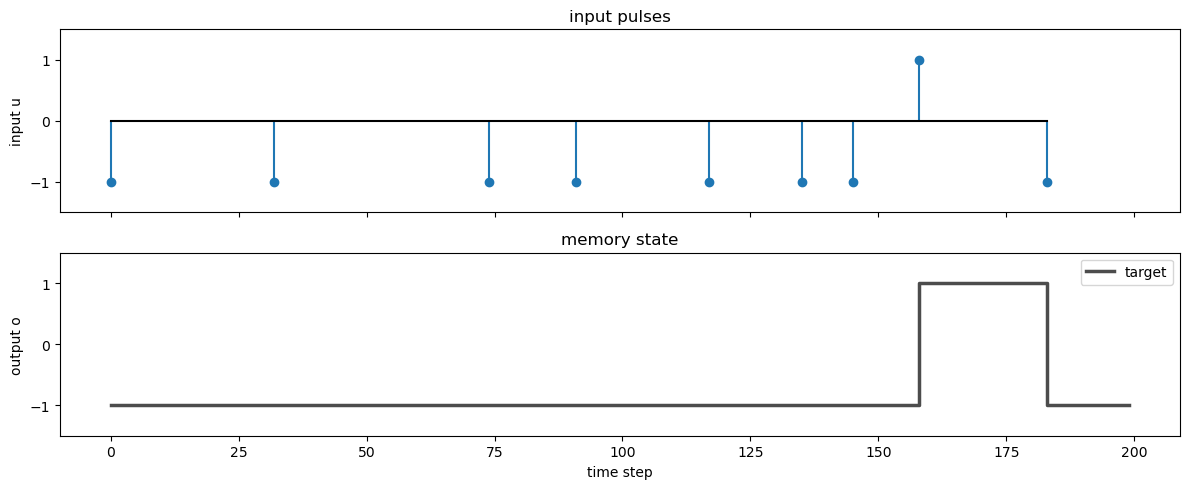

epoch  100/500  mse 0.057052
epoch  200/500  mse 0.039369
epoch  300/500  mse 0.028080
epoch  400/500  mse 0.013080
epoch  500/500  mse 0.007366


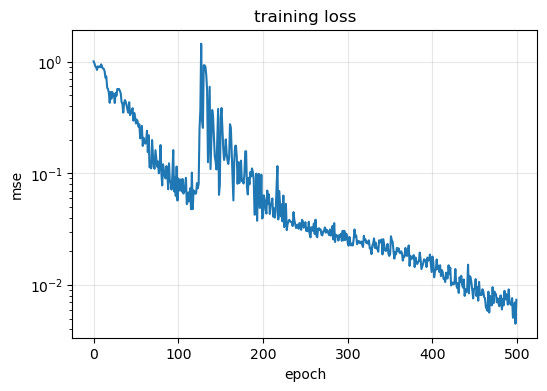

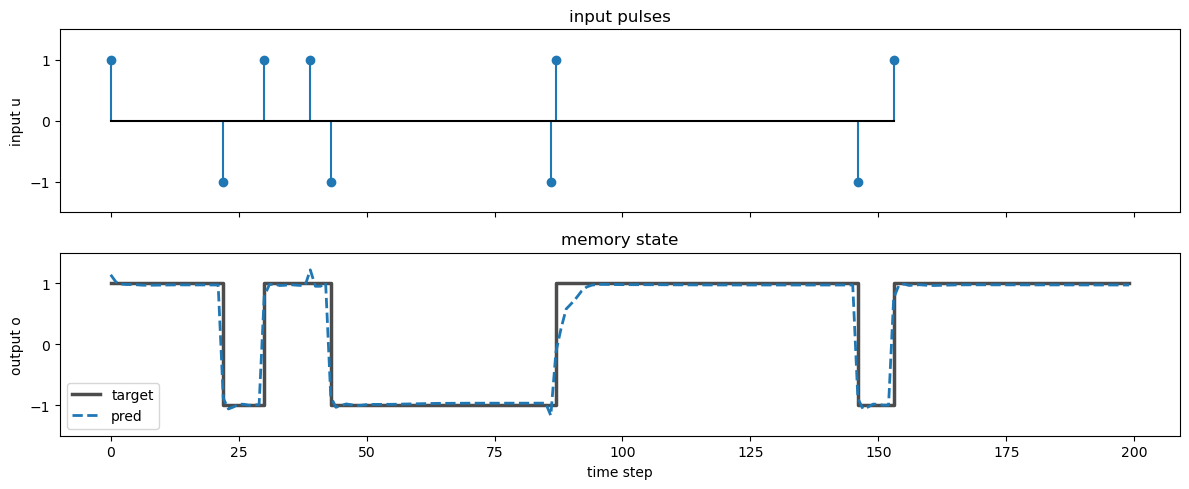

test mse: 0.007123163901269436


In [ ]:
task = SimpleFlipFlopTask(batch_size=32, seq_len=200, flip_prob=0.05)
model = SimpleRNN(input_size=1, hidden_size=50, output_size=1, tau=2.0, dt=1.0).to(device)

plot_trial(task, model=None, seq_len=200, seed=5)

losses = train(model, task, n_epochs=500, lr=1e-2, batch_size=32, regenerate_each_epoch=True, verbose=True)

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.title("training loss")
plt.grid(True, alpha=0.3)
plt.show()

plot_trial(task, model=model, seq_len=200, seed=5)

# quick test set metric
task.batch_size = 128
U_test, O_test = task.generate()
with torch.no_grad():
    mse = nn.MSELoss()(model(U_test.to(device)), O_test.to(device)).item()
print("test mse:", mse)


## Collect hidden states visited by the trained network

The trained RNN defines a trajectory in hidden space. We run the network on fresh sequences and record the full hidden state tensor

$$
R \in \mathbb{R}^{B\times(T+1)\times H}.
$$

We then flatten over batch and time to obtain a large set of visited states, and sample initial guesses \(r_0\) from this set.

This is a dynamical systems motivated choice: it biases the search toward fixed points that are relevant to the behavior the network actually uses to store memory.


In [ ]:
@torch.no_grad()
def collect_states(model, task, batch_size=64, seq_len=300, n_batches=2, seed=0):
    """Run the trained model and record hidden states.

    Returns
    -------
    states : torch.Tensor, shape (batch_size*n_batches, seq_len+1, H)
        Concatenated hidden state trajectories from multiple generated batches.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    old_bs, old_len = task.batch_size, task.seq_len
    task.batch_size = batch_size
    task.seq_len = seq_len

    all_states = []
    model.eval()
    for _ in range(n_batches):
        U, _ = task.generate()
        U = U.to(device)
        _, states = model(U, return_states=True)   # states: (B, T+1, H)
        all_states.append(states)

    task.batch_size, task.seq_len = old_bs, old_len
    return torch.cat(all_states, dim=0)            # (B*n_batches, T+1, H)


@torch.no_grad()
def sample_r_from_states(states, n_samples=128, seed=0):
    """Uniformly sample hidden states to use as initial guesses r0.

    states has shape (B, T+1, H). We reshape it to (B*(T+1), H) and sample rows.
    """
    g = torch.Generator(device=states.device)
    g.manual_seed(seed)

    B, Tp1, H = states.shape
    flat = states.reshape(B * Tp1, H)
    idx = torch.randint(0, flat.shape[0], (n_samples,), generator=g, device=states.device)
    return flat[idx].clone()


states = collect_states(model, task, batch_size=32, seq_len=200, n_batches=3, seed=0)
r0s = sample_r_from_states(states, n_samples=200, seed=0)

print("states shape:", tuple(states.shape))
print("r0s shape:", tuple(r0s.shape))


states shape: (96, 201, 50)
r0s shape: (200, 50)



The hidden state update used here is a leaky discretization of an overdamped continuous time system. With input set to zero, the update is

$$
r_{t+1} = (1-\alpha) r_t + \alpha\, \tanh\big(r_t W^T + b\big),
\quad \alpha = \frac{dt}{\tau}.
$$

In the small step limit this is an Euler step for

$$
\tau \frac{dr}{dt} = -r + \tanh\big(r W^T + b\big).
$$

A fixed point \(r^*\) satisfies the stationarity condition

$$
g(r^*) = -r^* + \tanh\big(r^* W^T + b\big) = 0.
$$

We find candidate fixed points by minimizing the squared residual

$$
S(r) = \lVert g(r) \rVert_2^2.
$$

This \(S(r)\) is a convenient scalar objective for root finding. It is not assumed to be a physical energy or a Lyapunov function globally, but its zeros coincide exactly with fixed points.

## Why sample initial conditions from the trajectory

Instead of initializing the solver from random vectors, we sample initial guesses from the hidden states the trained network actually visits. This concentrates the search near dynamically relevant regions, making it much more likely to recover the memory attractors and any nearby unstable fixed points that organize switching.


In [ ]:
def g_residual(r, W, b):
    """g(r) = -r + tanh(r W^T + b)."""
    a = r @ W.t() + b
    g = -r + torch.tanh(a)
    return g, a


def S_and_residual(r, W, b):
    """S(r) = ||g(r)||^2 and residual g(r). Supports r of shape (H,) or (N,H)."""
    if r.dim() == 1:
        r_ = r.unsqueeze(0)
        squeeze = True
    else:
        r_ = r
        squeeze = False

    a = r_ @ W.t() + b
    g = -r_ + torch.tanh(a)
    S = (g ** 2).sum(dim=-1)

    if squeeze:
        return S[0], g[0]
    return S, g


def solve_fixed_point_gd(
    r0, W, b,
    lr=1e-2,
    max_steps=4000,
    tol_S=1e-10,
    patience=300,
):
    """Minimize S(r) by Adam starting from r0."""
    Wc = W.detach()
    bc = b.detach()

    r = nn.Parameter(r0.detach().clone())
    opt = torch.optim.Adam([r], lr=lr)

    best_S = float("inf")
    best_r = None
    stall = 0

    for _ in range(max_steps):
        opt.zero_grad()
        S, _ = S_and_residual(r, Wc, bc)
        S.backward()
        opt.step()

        sval = float(S.detach().cpu())
        if sval < best_S:
            best_S = sval
            best_r = r.detach().clone()
            stall = 0
        else:
            stall += 1

        if sval < tol_S:
            break
        if stall >= patience:
            break

    r_star = best_r if best_r is not None else r.detach().clone()
    with torch.no_grad():
        S_final, g_final = S_and_residual(r_star, Wc, bc)
        return r_star, float(S_final.cpu()), float(torch.norm(g_final).cpu())


##  Optional refinement: 
After gradient descent gets close, we can apply a small number of Newton steps to solve $g(r)=0$ more sharply. Newton uses the Jacobian

$$
J_g(r) = \frac{\partial g}{\partial r}
       = -I + \mathrm{diag}(\mathrm{sech}^2(a))\,W,
\quad a = r W^T + b.
$$

In [ ]:


@torch.no_grad()
def newton_refine(r_init, W, b, steps=20, ridge=1e-6, damping=1.0, tol=1e-12):
    """Newton refinement for g(r)=0.

    Uses analytic Jacobian:
      J_g = -I + diag(sech^2(a)) W, where a = r W^T + b.

    ridge adds a small multiple of I for numerical stability.
    damping allows a damped Newton step if needed.
    """
    r = r_init.clone()
    H = r.numel()
    I = torch.eye(H, device=r.device, dtype=r.dtype)

    for _ in range(steps):
        g, a = g_residual(r, W, b)
        if torch.norm(g) < tol:
            break

        d = 1.0 - torch.tanh(a) ** 2           # sech^2(a)
        J = -I + (d.unsqueeze(1) * W)          # diag(d) @ W

        J_reg = J + ridge * I
        try:
            delta = torch.linalg.solve(J_reg, g)
        except RuntimeError:
            delta = torch.linalg.lstsq(J_reg, g).solution

        r_new = r - damping * delta

        # basic safeguard: keep the step if residual decreases
        g_new, _ = g_residual(r_new, W, b)
        if torch.norm(g_new) <= torch.norm(g):
            r = r_new
        else:
            r = r_new  # accept anyway; you can implement stronger line search if desired

    return r


def solve_fixed_point_hybrid(
    r0, W, b,
    gd_steps=1000,
    gd_lr=1e-2,
    tol_S=1e-10,
    patience=300,
    newton_steps=20,
    newton_ridge=1e-6,
    newton_damping=1.0,
):
    """Gradient descent on S(r) followed by Newton refinement on g(r)=0."""
    # run GD with a hard cap gd_steps
    Wc = W.detach()
    bc = b.detach()

    r = nn.Parameter(r0.detach().clone())
    opt = torch.optim.Adam([r], lr=gd_lr)

    best_S = float("inf")
    best_r = None
    stall = 0

    for _ in range(gd_steps):
        opt.zero_grad()
        S, _ = S_and_residual(r, Wc, bc)
        S.backward()
        opt.step()

        sval = float(S.detach().cpu())
        if sval < best_S:
            best_S = sval
            best_r = r.detach().clone()
            stall = 0
        else:
            stall += 1

        if sval < tol_S:
            break
        if stall >= patience:
            break

    r_star = best_r if best_r is not None else r.detach().clone()

    # Newton refinement (optional)
    r_star = newton_refine(
        r_star, Wc, bc,
        steps=newton_steps,
        ridge=newton_ridge,
        damping=newton_damping,
    )

    with torch.no_grad():
        S_final, g_final = S_and_residual(r_star, Wc, bc)
        return r_star, float(S_final.cpu()), float(torch.norm(g_final).cpu())


## Solve for fixed points from many trajectory sampled initial states

We now freeze \(W\) and \(b\) from the trained model, sample many initial guesses \(r_0\) from the hidden trajectory, and solve \(g(r)=0\) repeatedly.

The number of convergences into each fixed point gives an empirical proxy for the basin size under this sampling distribution.


n initializations: 200
n converged: 200
median S: 3.4434803099225864e-14
min S: 1.5224739600538245e-16


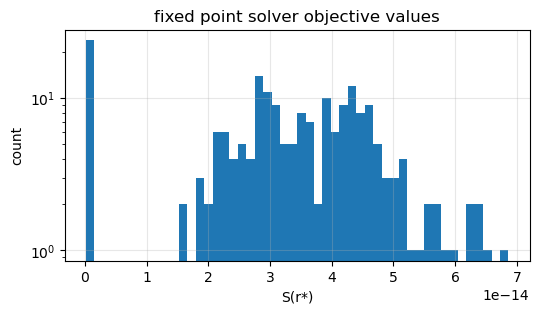

In [8]:
W = model.W_rec.detach()
b = model.b_rec.detach()

# Choose solver: "gd" or "hybrid"
solver = "hybrid"

solutions = []
for i in range(r0s.shape[0]):
    r0 = r0s[i]

    if solver == "gd":
        r_star, S_final, resid_norm = solve_fixed_point_gd(
            r0, W, b,
            lr=1e-2,
            max_steps=5000,
            tol_S=1e-10,
            patience=400,
        )
    else:
        r_star, S_final, resid_norm = solve_fixed_point_hybrid(
            r0, W, b,
            gd_steps=1000,
            gd_lr=1e-2,
            tol_S=1e-10,
            patience=400,
            newton_steps=20,
            newton_ridge=1e-6,
            newton_damping=1.0,
        )

    solutions.append({"r0": r0.detach().clone(), "r_star": r_star, "S": S_final, "resid": resid_norm})

# filter converged solutions
S_thresh = 1e-10
converged = [s for s in solutions if s["S"] < S_thresh]
print("n initializations:", len(solutions))
print("n converged:", len(converged))
print("median S:", float(np.median([s["S"] for s in solutions])))
print("min S:", float(np.min([s["S"] for s in solutions])))

# quick look at energy distribution
plt.figure(figsize=(6, 3))
plt.hist([s["S"] for s in solutions], bins=50)
plt.yscale("log")
plt.xlabel("S(r*)")
plt.ylabel("count")
plt.title("fixed point solver objective values")
plt.grid(True, alpha=0.3)
plt.show()


## Deduplicate fixed points and estimate stability

Many initial conditions converge to the same fixed point. We group solutions by Euclidean distance in hidden space.

We also estimate local stability by computing the spectral radius of the linearized leaky map

$$
r_{t+1} = (1-\alpha) r_t + \alpha\,\tanh(r_t W^T + b).
$$

A fixed point is locally stable for this discrete time update if the spectral radius $\rho(J_{\text{leaky}}) < 1$.


In [9]:
@torch.no_grad()
def unique_fixed_points(converged_solutions, dist_thresh=1e-3):
    """Greedy clustering of converged fixed points in r space."""
    reps = []
    sizes = []
    members = []  # indices into converged_solutions

    for idx, sol in enumerate(converged_solutions):
        r = sol["r_star"]
        placed = False
        for k, rep in enumerate(reps):
            if torch.norm(r - rep).item() < dist_thresh:
                sizes[k] += 1
                members[k].append(idx)
                placed = True
                break
        if not placed:
            reps.append(r.clone())
            sizes.append(1)
            members.append([idx])

    return reps, sizes, members


@torch.no_grad()
def spectral_radius_leaky(r_star, W, b, alpha):
    """Spectral radius of the Jacobian of the leaky update at r_star."""
    H = r_star.numel()
    I = torch.eye(H, device=r_star.device, dtype=r_star.dtype)

    a = r_star @ W.t() + b
    d = 1.0 - torch.tanh(a) ** 2         # sech^2(a)
    JF = d.unsqueeze(1) * W              # derivative of F(r)=tanh(r W^T + b)
    J_leaky = (1.0 - alpha) * I + alpha * JF

    eigvals = torch.linalg.eigvals(J_leaky)
    return torch.max(torch.abs(eigvals)).item()


reps, sizes, members = unique_fixed_points(converged, dist_thresh=1e-3)
rhos = [spectral_radius_leaky(r, W, b, alpha=model.alpha) for r in reps]

print("unique fixed points:", len(reps))
print("largest basin sizes:", sorted(sizes, reverse=True)[:10])
print("spectral radii (first few):", [round(x, 4) for x in rhos[:10]])


unique fixed points: 3
largest basin sizes: [92, 84, 24]
spectral radii (first few): [1.2089, 0.7586, 0.7563]



Linearizing the map around \(r^*\) gives the Jacobian

$$
J_{\text{leaky}}(r^*) = (1-\alpha)I + \alpha\,J_F(r^*),
\qquad
J_F(r^*) = \mathrm{diag}(\mathrm{sech}^2(a^*))\,W,
\quad a^* = r^* W^T + b.
$$

A sufficient local stability criterion for the discrete time dynamics is that the spectral radius
$$
\rho(J_{\text{leaky}}) < 1
$$.


Fixed points live in \(H\) dimensions. To visualize them we project the fixed point vectors to 2D with PCA.

Point size encodes how many sampled initial conditions converged to that fixed point. This is an empirical basin count under the trajectory based sampling distribution.

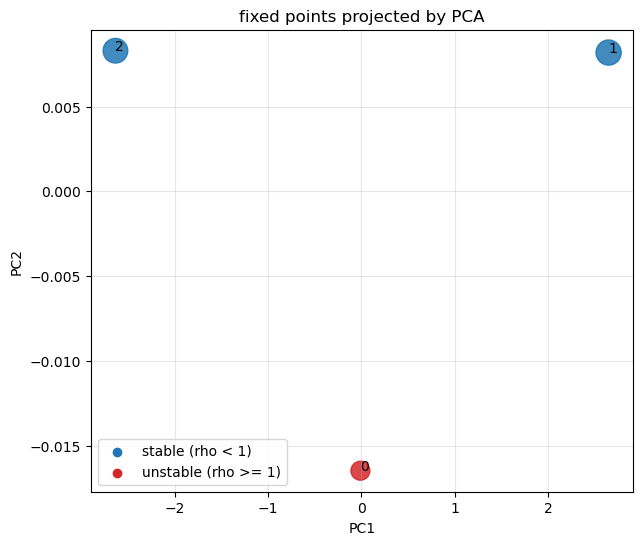

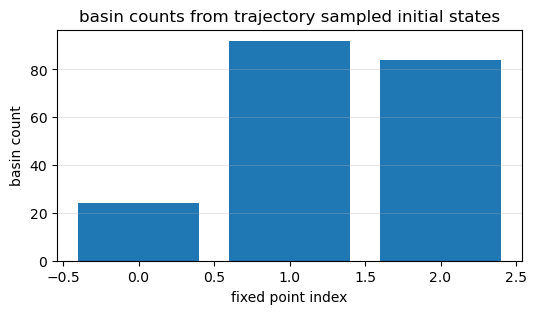

In [10]:
def pca_project(X, k=2):
    """PCA via SVD. X is (n, d) numpy array."""
    Xc = X - X.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    comps = Vt[:k]
    Z = Xc @ comps.T
    return Z, comps


if len(reps) == 0:
    print("no converged fixed points to plot")
else:
    R = torch.stack(reps, dim=0).detach().cpu().numpy()
    Z, _ = pca_project(R, k=2 if R.shape[0] >= 2 else 1)

    if Z.shape[1] == 1:
        x = Z[:, 0]
        y = np.zeros_like(x)
    else:
        x, y = Z[:, 0], Z[:, 1]

    basin_sizes = np.array(sizes, dtype=float)
    sizes_plot = 40 + 30 * np.sqrt(basin_sizes)

    stable = np.array([rho < 1.0 for rho in rhos])
    colors = np.where(stable, "C0", "C3")

    plt.figure(figsize=(7, 6))
    plt.scatter(x, y, s=sizes_plot, c=colors, alpha=0.85)

    # annotate indices
    for i in range(len(reps)):
        plt.text(x[i], y[i], str(i), fontsize=10)

    # manual legend
    plt.scatter([], [], c="C0", label="stable (rho < 1)")
    plt.scatter([], [], c="C3", label="unstable (rho >= 1)")
    plt.legend()

    plt.title("fixed points projected by PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2" if Z.shape[1] > 1 else "")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.bar(np.arange(len(basin_sizes)), basin_sizes)
    plt.xlabel("fixed point index")
    plt.ylabel("basin count")
    plt.title("basin counts from trajectory sampled initial states")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()
